# STOCK PRICE PREDICTION
### Project Description
- Predicting stock market prices is a complex task that traditionally involves extensive human-computer interaction.
- We propose an learning algorithm that utilizes a kind of recurrent neural network (RNN) called Long Short Term Memory (LSTM).
- This will provide more accurate results when compared to existing stock price prediction algorithms.

### Modules Used
- <b>Numpy</b> - NumPy is a library for multi-dimensional arrays , along with a large collection of high-level mathematical functions to operate on these arrays.
- <b>Pandas </b>- pandas is a software library for data manipulation and analysis. It offers data structures and operations for manipulating numerical tables and time series.
- <b>Matplotlib</b> - Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy
- <b>Keras</b> - Keras is an open-source software library that provides a Python interface for artificial neural networks. Keras acts as an interface for the TensorFlow library. 
- <b>sklearn</b> - Scikit-learn is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms.
- <b>Requests</b> - Requests is a Python HTTP library, released under the Apache License 2.0. The goal of the project is to make HTTP requests simpler and more human-friendly.
- <b>BeautifulSoup</b> - Beautiful Soup is a Python package for parsing HTML and XML documents. It creates a parse tree for parsed pages that can be used to extract data from HTML.
- <b>Yfinance</b> - Yfinance package helps to to access the share-price details of all companies listed in the United States.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
import yfinance as yf

### Retrieving yfinance codes
The following function retrieves the data i.e. yfinance codes corresponding to the companies from the website https://stockanalysis.com/stocks/ and searches for the given parameter(i.e company).

In [2]:
def codes(name):
    yfcode_url="https://stockanalysis.com/stocks/"
    yfcode_html=requests.get(yfcode_url).text
    yfsoup=BeautifulSoup(yfcode_html,"html5lib")
    uls=yfsoup.find_all("ul",attrs={"class":"no-spacing"})
    uls_a=uls[0].find_all("a")
    yfcodes={}
    l = []
    for i in uls_a:
        if name.lower() in i.string.lower():
            l.append(i.string)
    return l

### Creating DataFrame and Duplicate DataFrame
In the dataframe function , the DataFrame is created using the Ticker function from yfinanace module. The data is cleaned in accordance with the Requirements.

Now , In create_new_dataset function , a copy of previous DataFrame is created with required columns(Date,Close).

In [3]:
def dataframe(code):
    data = yf.Ticker(code)
    df = data.history(period="max")
    df.reset_index(inplace=True)
    df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
    df["Year"]=pd.DatetimeIndex(df.Date).year
    df=df[df.Year>=2000]
    df.index=df['Date']
    return df

In [4]:
def create_new_dataset(code):
    df = dataframe(code)
    data=df.sort_index(ascending=True,axis=0)
    new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
    for i in range(0,len(data)):
        new_dataset["Date"][i]=data['Date'][i]
        new_dataset["Close"][i]=data["Close"][i]
    #print(new_dataset)
    return [df,new_dataset]

### Scaling the Dataset
This function scales and translates each feature individually such that it is in the given range on the training set between zero and one. Later , we create the x_train_data and y_train_data as numpy arrays which will be used for training the model.

In [5]:
#scaling the dataset

def scaling(code):
    df,new_dataset = create_new_dataset(code)
    while(True):
        try:
            final_dataset=new_dataset.values
            n=df.shape[0]
            td = (n*8)//10
            train_data=final_dataset[0:td]
#print(train_data)
            valid_data=final_dataset[td:]
            scaler=MinMaxScaler(feature_range=(0,1))
            try:
                new_dataset.index=new_dataset.Date
                new_dataset.drop("Date",axis=1,inplace=True)
                scaled_data=scaler.fit_transform(final_dataset)
            except:
                pass
            try:
                scaled_data=scaler.fit_transform(final_dataset)
            except:
                pass
            x_train_data,y_train_data=[],[]
            for i in range(60,len(train_data)):
                x_train_data.append(scaled_data[i-60:i,0])
                y_train_data.append(scaled_data[i,0])
    
            x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
            x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
            break
        except:
            pass
    return [new_dataset,valid_data,x_train_data,y_train_data,scaler,td]

### Training the Model
In the following function we are using the lstm model to train the data.LSTM (Long short-term memory) is an artificial recurrent neural network architecture used in the field of deep learning.LSTMs are very powerful in sequence prediction problems because they’re able to store past information. This is important in our case because the previous price of a stock is crucial in predicting its future price.

In order to build the LSTM, we need to import a couple of modules from Keras:
- Sequential for initializing the neural network
- Dense for adding a densely connected neural network layer
- LSTM for adding the Long Short-Term Memory layer
- Dropout for adding dropout layers that prevent overfitting


In [6]:
def model(code):
    new_dataset,valid_data,x_train_data,y_train_data,scaler,td = scaling(code)
    lstm_model=Sequential()
    lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))
    inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
    inputs_data=inputs_data.reshape(-1,1)
    inputs_data=scaler.transform(inputs_data)
    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=5,batch_size=10,verbose=2)
    return [new_dataset,inputs_data,lstm_model,scaler,td]

### Predicting the Stock
In the predict function we are going to predict future stock prices we need to do a couple of things after loading in the test set:

- Merge the training set and the test set on the 0 axis.
- Set the time step as 60 (as seen previously)
- Reshape the dataset as done previously


In [7]:
def predict(code):
    new_dataset,inputs_data,lstm_model,scaler,td = model(code)
    X_test=[]
    for i in range(60,inputs_data.shape[0]):
        X_test.append(inputs_data[i-60:i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    predicted_closing_price=lstm_model.predict(X_test)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
    lstm_model.save("saved_model.h5")
    return [new_dataset,predicted_closing_price,td]

### Plotting the Results
In the prediction_plot function we use Matplotlib to visualize the result of the predicted stock price and the real stock price.The predictions are plotted for the Close based on the Date.

In [8]:
def prediction_plot(code,company):
    new_dataset,predicted_closing_price,td = predict(code)
    train_data=new_dataset[:td]
    valid_data=new_dataset[td:]
    valid_data['Predictions'] = predicted_closing_price.copy()
    plt.plot(train_data["Close"])
    plt.plot(valid_data[['Close',"Predictions"]])
    plt.xlabel("Year",fontsize=20)
    plt.ylabel("Closing Price",fontsize=20)
    plt.title(company+"'s Stock Prediction",fontdict={"fontsize":30,"color":"red"})
    plt.legend(["Training Data","Original Closing Value","Predicted Closing Value"],prop={"size":25})


By using the Stock_Prediction function , The name of the company is taken as the input from the user for which the predicted stock price is plotted by using the above functions.

In [9]:
def Stock_Prediction():
    company = input("Enter Company Name : ")
    l = codes(company)
    if len(l)==0:
        print("Company Not Found")
    elif len(l)==1:
        code = l[0].split(" - ")
        prediction_plot(code[0],code[1])
    else:
        print(l)
        code = input("Enter Required code from list : ")
        for i in l:
            if i.startswith(code.upper()):
                company = i.split(" - ")[1]
                break
        prediction_plot(code.upper(),company)

Enter Company Name : amazon
Epoch 1/5
428/428 - 22s - loss: 7.5192e-05
Epoch 2/5
428/428 - 9s - loss: 1.3839e-05
Epoch 3/5
428/428 - 10s - loss: 1.1286e-05
Epoch 4/5
428/428 - 10s - loss: 1.1461e-05
Epoch 5/5
428/428 - 10s - loss: 1.1493e-05


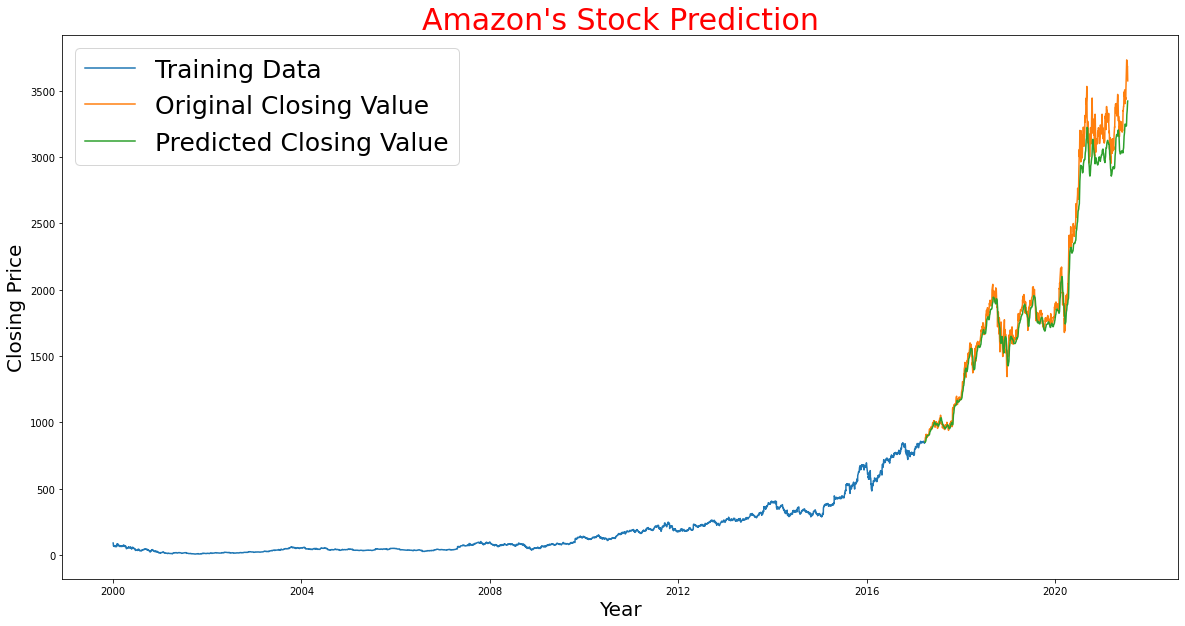

In [10]:
Stock_Prediction()

Enter Company Name : praa
Epoch 1/5
371/371 - 11s - loss: 0.0034
Epoch 2/5
371/371 - 8s - loss: 6.6127e-04
Epoch 3/5
371/371 - 9s - loss: 5.3598e-04
Epoch 4/5
371/371 - 9s - loss: 4.9411e-04
Epoch 5/5
371/371 - 10s - loss: 4.2703e-04


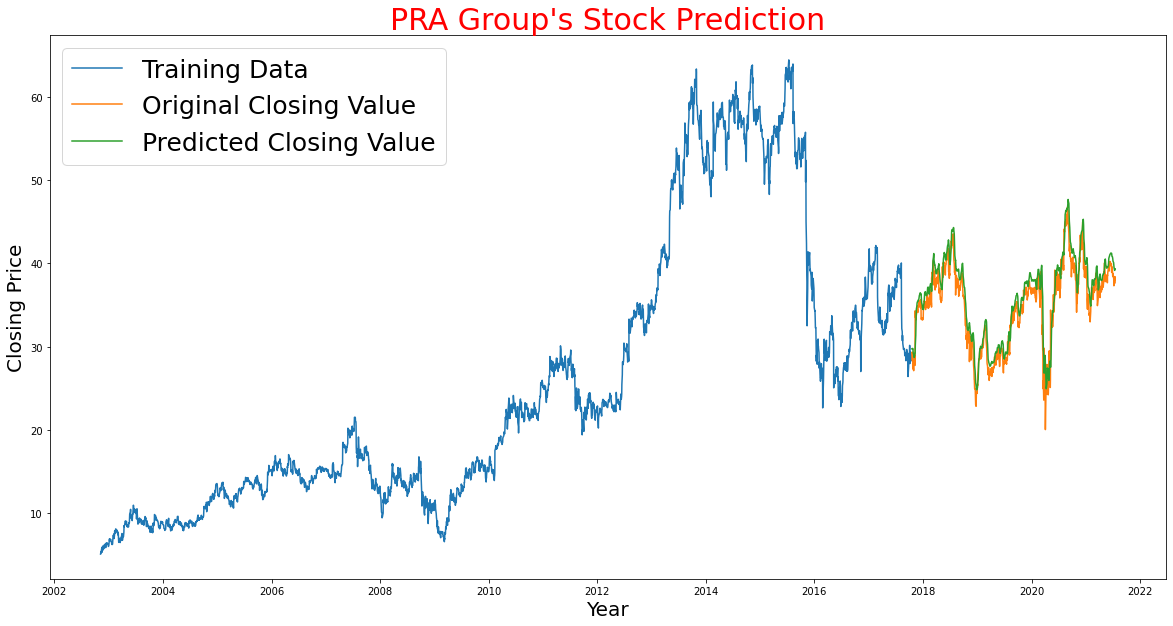

In [12]:
Stock_Prediction()

Enter Company Name : tata
Epoch 1/5
333/333 - 9s - loss: 0.0044
Epoch 2/5
333/333 - 7s - loss: 7.4197e-04
Epoch 3/5
333/333 - 7s - loss: 5.3439e-04
Epoch 4/5
333/333 - 8s - loss: 4.5602e-04
Epoch 5/5
333/333 - 8s - loss: 3.9718e-04


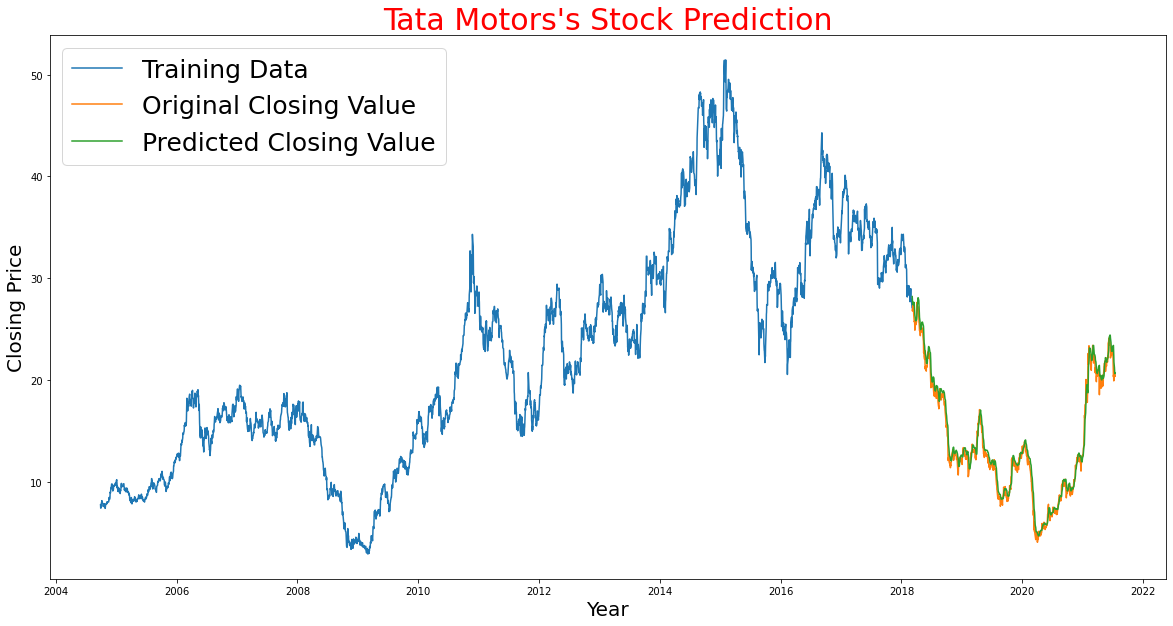

In [11]:
Stock_Prediction()

Enter Company Name : microsoft
Epoch 1/5
428/428 - 11s - loss: 7.1715e-05
Epoch 2/5
428/428 - 9s - loss: 1.6449e-05
Epoch 3/5
428/428 - 11s - loss: 1.3362e-05
Epoch 4/5
428/428 - 11s - loss: 1.1999e-05
Epoch 5/5
428/428 - 11s - loss: 9.4441e-06


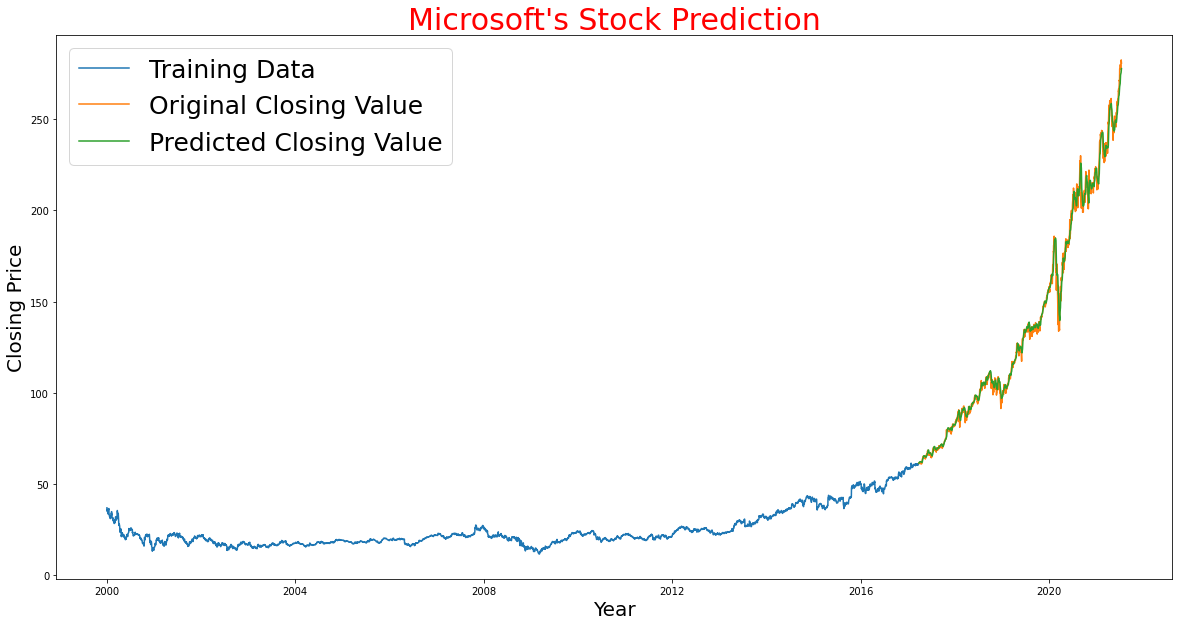

In [13]:
Stock_Prediction()